# Imports

In [4]:
!wget https://pastebin.com/raw/fKfRrUvs -O utilities3.py
import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *
torch.manual_seed(0)
np.random.seed(0)

--2023-11-05 15:21:44--  https://pastebin.com/raw/fKfRrUvs
Resolving pastebin.com (pastebin.com)... 104.20.68.143, 104.20.67.143, 172.67.34.170, ...
Connecting to pastebin.com (pastebin.com)|104.20.68.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘utilities3.py’

    [ <=>                                   ] 9,874       --.-K/s   in 0.002s  

2023-11-05 15:21:44 (3.82 MB/s) - ‘utilities3.py’ saved [9874]



# Architecture

## FNO

This section implements the FNO as described in: https://arxiv.org/abs/2010.08895

In [25]:
import torch.nn as nn
import torch

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  12, 12, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # TODO: when s & r are added, change 1 to 3
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = self.q(x)

        x = x.permute(0, 2, 3, 1)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


## Loss

Loss function used in https://arxiv.org/abs/2010.08895

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()


        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def rel(self, x, y):
        num_examples = x.size()[0]

        # print(x.shape)
        # print(y.shape)

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Data Loading

[[1.35508543e-275 2.11314859e-273 2.68702010e-271 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.47096408e-269 8.53153595e-267 1.08484603e-264 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.80110308e-262 2.80867785e-260 3.57143547e-258 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [1.98202580e-047 3.09081254e-045 3.93018998e-043 ... 2.44495455e-247
  9.65724441e-254 3.11037800e-260]
 [2.02686845e-049 3.16074111e-047 4.01910917e-045 ... 2.50027080e-249
  9.87573622e-256 3.18074923e-262]
 [1.69012699e-051 2.63561942e-049 3.35137926e-047 ... 2.08487885e-251
  8.23499342e-258 2.65230342e-264]]


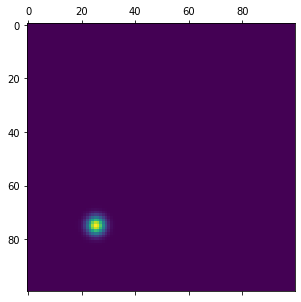

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 100)
z = np.linspace(0, 1, 100)

XX, ZZ = np.meshgrid(x, z)

def gaussian_function(XX, ZZ, src):
    x_src, z_src = src[0], src[1]
    sigma2 = 0.0005
    grid = np.sqrt(1/sigma2 * ((XX-x_src)**2 + (ZZ-z_src)**2))
    grid = 1 / (sigma2 * np.sqrt(2*math.pi)) * (np.exp(-0.5 * grid**2))
    return grid

x_coordinate = 25.5/100
y_coordinate = 75.8/100

gf = gaussian_function(XX, ZZ, (x_coordinate, y_coordinate))

print(gf)
plt.matshow(gf)

In [9]:
from torch.utils.data import DataLoader
import os
import pandas as pd
# from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class EikonalDataset(Dataset):
    def __init__(self, fid, dataset_type):
        train_test_split = 2500
        max_val = 100
        if dataset_type == 'train':
            self.vels=torch.tensor(fid["vels"][:train_test_split])
            # print(self.vels[0].cpu().numpy())

            self.kernels=torch.tensor(fid["kernels"][:train_test_split])
            self.source_loc=torch.tensor(fid["source_loc"][:train_test_split])
            self.rec_loc=torch.tensor(fid["rec_loc"][:train_test_split])
        if dataset_type == 'test':
            self.vels=torch.tensor(fid["vels"][train_test_split:])
            self.kernels=torch.tensor(fid["kernels"][train_test_split:])
            self.source_loc=torch.tensor(fid["source_loc"][train_test_split:])
            self.rec_loc=torch.tensor(fid["rec_loc"][train_test_split:])
        self.XX, self.ZZ = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

        self.source_loc_gaussian=torch.tensor([gaussian_function(self.XX, self.ZZ, np.asarray(s)[::-1]/max_val) for s in self.source_loc])
        self.rec_loc_gaussian=torch.tensor([gaussian_function(self.XX, self.ZZ, np.asarray(s)[::-1]/max_val) for s in self.rec_loc])


    def __getitem__(self, i):
        # x = torch.from_numpy(np.asarray([np.float32(self.vels[i]), np.float32(gaussian_function(self.XX, self.ZZ, self.source_loc[i])),np.float32(gaussian_function(self.XX, self.ZZ, self.rec_loc[i]))]))
        x = torch.from_numpy(np.asarray([np.float32(self.vels[i]), np.float32(self.source_loc_gaussian[i]),np.float32(self.rec_loc_gaussian[i])]))
        y = torch.from_numpy(np.asarray([np.float32(self.kernels[i])]))

        return {'x': x, 'y': y, 'source': self.source_loc[i], 'receiver': self.rec_loc[i]}

    def __len__(self):
        return len(self.vels)


filename = '/central/groups/mlprojects/eikonal/Data/DatVel30_Sou100_Rec100_Dim100x100_Downsampled.npz'
with np.load(filename, allow_pickle=True) as fid:
    train_data = EikonalDataset(fid, 'train')
    print(train_data)
    test_data = EikonalDataset(fid, 'test')

## Encoding

In [10]:

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001, time_last=True):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T in 1D
        # x could be in shape of ntrain*w*l or ntrain*T*w*l or ntrain*w*l*T in 2D
        x_np = x.detach().numpy()
        self.mean = torch.mean(x, 0)
        self.min = np.amin(x_np)
        self.max = np.amax(x_np)
        # self.std = torch.std(x, 0)
        self.std = torch.from_numpy(np.std(x_np, axis=0))

        self.eps = eps
        self.time_last = time_last # if the time dimension is the last dim

        print (torch.min(self.mean), torch.max(self.mean))

        print (torch.min(self.std), torch.max(self.std))

    def encode(self, x):
        x = (x - self.min) / (self.max - self.min)
        return x

    def decode(self, x, sample_idx=None):
        # sample_idx is the spatial sampling mask
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if self.mean.ndim == sample_idx.ndim or self.time_last:
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if self.mean.ndim > sample_idx.ndim and not self.time_last:
                    std = self.std[...,sample_idx] + self.eps # T*batch*n
                    mean = self.mean[...,sample_idx]
        # x is in shape of batch*(spatial discretization size) or T*batch*(spatial discretization size)
        x = (x * (self.max - self.min)) + self.min
        return x

    def to(self, device):
        if torch.is_tensor(self.mean):
            self.mean = self.mean.to(device)
            self.std = self.std.to(device)
        else:
            self.mean = torch.from_numpy(self.mean).to(device)
            self.std = torch.from_numpy(self.std).to(device)
        return self

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [11]:
# def extract_input(data):
#   ret = []
#   for
x_train_vels = train_data.vels
print(x_train_vels[0])

x_train_src = train_data.source_loc_gaussian
x_train_rec = train_data.rec_loc_gaussian
y_train = train_data.kernels

x_test_vels = test_data.vels
x_test_src = test_data.source_loc_gaussian
x_test_rec = test_data.rec_loc_gaussian
y_test = test_data.kernels

tensor([[4.9691, 5.0128, 5.0789,  ..., 5.3091, 5.1106, 4.9340],
        [4.9501, 4.9531, 5.0404,  ..., 5.2679, 5.1093, 4.9462],
        [4.9876, 5.0074, 5.0727,  ..., 5.2045, 5.0689, 4.9185],
        ...,
        [5.5198, 5.5469, 5.5601,  ..., 5.4324, 5.2984, 5.2297],
        [5.5468, 5.5726, 5.5917,  ..., 5.3884, 5.2852, 5.2815],
        [5.5677, 5.5921, 5.6165,  ..., 5.4000, 5.3337, 5.3375]],
       dtype=torch.float64)


In [12]:
x_normalizer = UnitGaussianNormalizer(x_train_vels)
print ("Encoding x train data")
x_train_vels = x_normalizer.encode(x_train_vels)
print (x_train_vels[0])
print()

print ("Encoding x test data")
x_test_vels = x_normalizer.encode(x_test_vels)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)


x_train_vels = x_train_vels.reshape(len(x_train_vels),100,100,1) # TODO: Later change to s (100), s (100), n_channels (3)
x_test_vels = x_test_vels.reshape(len(x_test_vels),100,100,1)

x_train_src = x_train_src.reshape(len(x_train_src),100,100,1) # TODO: Later change to s (100), s (100), n_channels (3)
x_test_src = x_test_src.reshape(len(x_test_src),100,100,1)

x_train_rec = x_train_rec.reshape(len(x_train_rec),100,100,1) # TODO: Later change to s (100), s (100), n_channels (3)
x_test_rec = x_test_rec.reshape(len(x_test_rec),100,100,1)

x_train = torch.cat((x_train_vels, x_train_src, x_train_rec), 3)
x_test = torch.cat((x_test_vels, x_test_src, x_test_rec), 3)

# x_train_vels = x_train_vels.reshape(len(x_train_vels), 1, 100,100) # TODO: Later change to s (100), s (100), n_channels (3)
# x_test_vels = x_test_vels.reshape(len(x_test_vels), 1, 100,100)

# x_train_src = x_train_src.reshape(len(x_train_src), 1, 100,100) # TODO: Later change to s (100), s (100), n_channels (3)
# x_test_src = x_test_src.reshape(len(x_test_src),1, 100,100)

# x_train_rec = x_train_rec.reshape(len(x_train_rec), 1, 100,100) # TODO: Later change to s (100), s (100), n_channels (3)
# x_test_rec = x_test_rec.reshape(len(x_test_rec), 1, 100,100)

# x_train = torch.cat((x_train_vels, x_train_src, x_train_rec), 1)
# x_test = torch.cat((x_test_vels, x_test_src, x_test_rec), 1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=16, shuffle=False)

tensor(1.3595, dtype=torch.float64) tensor(6.7437, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(4.4942e-13, dtype=torch.float64)
Encoding x train data
tensor([[0.6704, 0.6785, 0.6908,  ..., 0.7336, 0.6967, 0.6639],
        [0.6669, 0.6674, 0.6836,  ..., 0.7259, 0.6964, 0.6661],
        [0.6738, 0.6775, 0.6896,  ..., 0.7141, 0.6889, 0.6610],
        ...,
        [0.7727, 0.7777, 0.7802,  ..., 0.7564, 0.7316, 0.7188],
        [0.7777, 0.7825, 0.7860,  ..., 0.7483, 0.7291, 0.7284],
        [0.7816, 0.7861, 0.7906,  ..., 0.7504, 0.7381, 0.7388]],
       dtype=torch.float64)

Encoding x test data
tensor(-0.0043) tensor(0.)
tensor(0.) tensor(0.0210)


## Visualization

Graphs inputs and outputs

In [13]:
data_iter = iter(train_loader)

torch.Size([16, 100, 100, 3])
torch.Size([16, 100, 100])


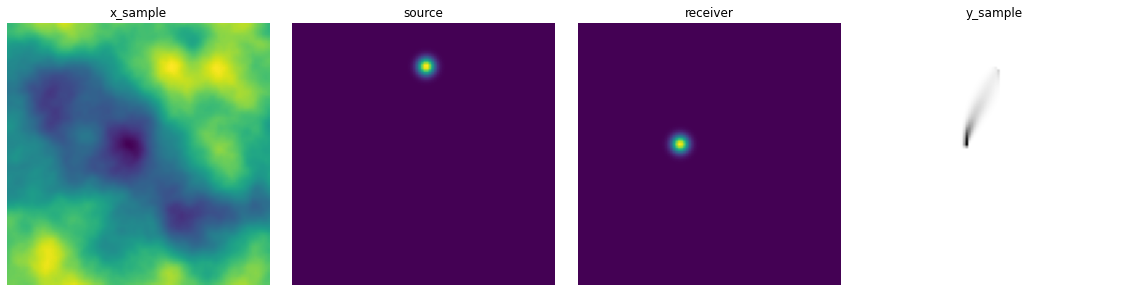

In [14]:
x_sample, y_sample = next(data_iter)
x_sample, y_sample = x_sample.float(), y_sample.float()
print(x_sample.shape)  # this will show the shape of the x_sample tensor
print(y_sample.shape)  # this will show the shape of the y_sample tensor

import matplotlib.pyplot as plt
import numpy as np


x_np0 = x_sample[0,:,:,0].cpu().numpy()
x_np1 = x_sample[0,:,:,1].cpu().numpy()
x_np2 = x_sample[0,:,:,2].cpu().numpy()

# x_np = x_sample[0, :, :, 0].squeeze().numpy()  # taking the first item from the batch, and removing singleton dimensions
y_np = y_sample[0].squeeze().numpy()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Display the images
axs[0].imshow(x_np0, cmap='viridis')  # you can change the colormap if needed
axs[0].set_title("x_sample")
axs[0].axis('off')  # Hide the axis values

axs[1].imshow(x_np1, cmap='viridis')  # you can change the colormap if needed
axs[1].set_title("source")
axs[1].axis('off')  # Hide the axis values

axs[2].imshow(x_np2, cmap='viridis')  # you can change the colormap if needed
axs[2].set_title("receiver")
axs[2].axis('off')  # Hide the axis values

axs[3].imshow(y_np, cmap='gray')
axs[3].set_title("y_sample")
axs[3].axis('off')  # Hide the axis values

plt.tight_layout()
plt.show()

# Training

Hyperparameters:

In [15]:
sub = 1
S = 100
T_in = 10
T = 40 # T=40 for V1e-3; T=20 for V1e-4; T=10 for V1e-5;
step = 1

batch_size = 4
learning_rate = 0.001
epochs = 5
iterations = epochs*(32//batch_size)

modes = 12
width = 32

In [16]:
from IPython import display
%matplotlib inline
def plot_loss_curves(train_fno, test_fno, mode, width, epoch):
    display.clear_output(wait=True)
    # display.display(pl.gcf())
    plt.close('all')
    x = [i for i in range(len(train_fno))]
    plt.plot(x[1::1], train_fno[1::5])
    stem = '/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Losses/'
    filename = stem + 'loss-mode-' + str(mode) + '-width-' + str(width) + '-epoch-' + str(epoch)  + ".jpg"
    title = 'Loss Curves (Mode: ' + str(mode) + ' Width: ' + str(width) + ' Epoch: ' + str(epoch) + ")"
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (L2)')
    plt.plot(x[1::1], test_fno[1::5])
    plt.legend(['Train', 'Test'])
    plt.savefig(filename)
    plt.show()


In [19]:
from IPython import display
%matplotlib inline
def plot_residuals(losses, mode, width, epoch, isTest=True):
    stem = '/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Losses/'
    filename = stem + 'residuals-mode-' + str(mode) + '-width-' + str(width) + '-epoch-' + str(epoch)  + ".jpg"
    title = 'Residuals Histogram (Mode: ' + str(mode) + ' Width: ' + str(width) + ' Epoch: ' + str(epoch) + ")"
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Amount')
    plt.hist(losses, bins=30)
    plt.legend('Train' if not isTest else 'Test')
    plt.savefig(filename)
    plt.show()

Training:

run through test


AttributeError: 'builtin_function_or_method' object has no attribute 'rfft2'

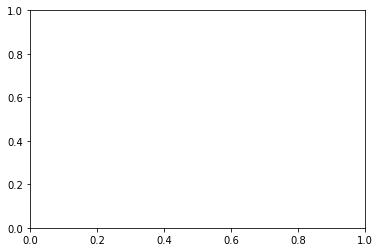

In [26]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

fno_model = FNO2d(modes, modes, width)

test_fno = []
train_fno = []

optimizer = torch.optim.AdamW(fno_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

myloss = LpLoss(size_average=False)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ep in range(1, epochs + 1):
    if ep % 200 == 0:
        torch.save(fno_model, '/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Data/model-1000-v2-epoch-'+ str(ep))

    fno_model.eval()
    test_l2 = 0.0

    test_losses = []

    i = 0

    print ("run through test")
    with torch.no_grad():
        for x, y in test_loader:
            i += 1
            if i % 10 != 0:
                continue
            # x, y = x.cuda(), y.cuda()
            x, y = x.float(), y.float()

            out = fno_model(x)
            out = out.squeeze(-1)
            y = y_normalizer.decode(y)

            out = y_normalizer.decode(out)

            test_l2 += myloss(out, y.view(batch_size,-1)).item()
            test_losses.append(test_l2)

    print ("run through train")
    fno_model.train()
    train_l2 = 0
    for x, y in train_loader:
        i += 1
        if i % 10 != 0:
            continue
        # x, y = x.cuda(), y.cuda()
        x, y = x.float(), y.float()

        optimizer.zero_grad()
        out = fno_model(x)
        out = out.squeeze(-1)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out, y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        scheduler.step()
        train_l2 += loss.item()

    train_l2/= 2500.0
    test_l2 /= 500.0
    print(f"epoch: {ep}, \tl2 train: {train_l2} \tl2 test: {test_l2}")


    train_fno.append(train_l2)
    test_fno.append(test_l2)
    plot_loss_curves(train_fno, test_fno, modes, width, ep)
    if ep % 1 == 0:
        plot_loss_curves(train_fno, test_fno, modes, width, ep)
        plot_residuals(test_losses, modes, width, ep)
        for i in range(len(train_fno)):
            print(f"epoch: {i}, \tl2 train: {train_fno[i]} \tl2 test: {train_fno[i]}")

note: I messed up the divisor for the l2 loss; will fix later but the nums
above are not accurate

### Loss Curves


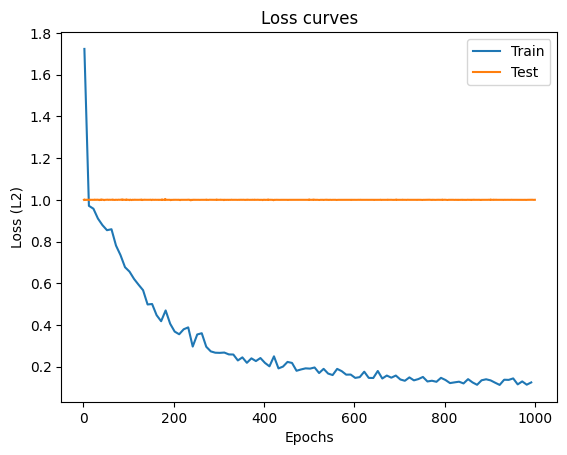

In [ ]:
x = [i for i in range(1, epochs + 1)]
import matplotlib.pyplot as plt
import numpy as np
plt.plot(x[1::10], train_fno[1::10])
plt.title("Loss curves")
plt.xlabel('Epochs')
plt.ylabel('Loss (L2)')
plt.plot(x, test_fno)
plt.xlabel('Epochs')
plt.ylabel('Loss (L2)')
plt.legend(['Train', 'Test'])
plt.show()

### Visualization

In [ ]:
data_iter = iter(test_loader)

In [ ]:
x_sample, y_sample = next(data_iter)
x_sample, y_sample = x_sample.float(), y_sample.float()
# x_sample = x_sample.unsqueeze(-1)
if torch.cuda.is_available():
    x_sample = x_sample.cuda()

# Make sure your model is in evaluation mode for inference
fno_model.eval()

# Forward pass
with torch.no_grad():  # Deactivate gradients for the following code
    out_sample1 = fno_model(x_sample)
out_sample1 = out_sample1.detach().cpu().numpy()

NameError: ignored

In [ ]:
data_iter = iter(test_loader)
x_sample, y_sample = next(data_iter)
x_sample, y_sample = next(data_iter)
x_sample, y_sample = x_sample.float(), y_sample.float()
# x_sample = x_sample.unsqueeze(-1)
if torch.cuda.is_available():
    x_sample = x_sample.cuda()
y_sample = y_normalizer.decode(y_sample)

# Make sure your model is in evaluation mode for inference
fno_model200.eval()
fno_model400.eval()
fno_model600.eval()
fno_model800.eval()
fno_model1000.eval()

# Forward pass
with torch.no_grad():  # Deactivate gradients for the following code
    out_sample1 = y_normalizer.decode(fno_model200(x_sample))
    # y_normalizer.decode(y_sample)
    out_sample2 = y_normalizer.decode(fno_model400(x_sample))
    out_sample3 = y_normalizer.decode(fno_model600(x_sample))
    out_sample4 = y_normalizer.decode(fno_model800(x_sample))
    out_sample5 = y_normalizer.decode(fno_model1000(x_sample))
out_sample1 = out_sample1.detach().cpu().numpy()
out_sample2 = out_sample2.detach().cpu().numpy()
out_sample3 = out_sample3.detach().cpu().numpy()
out_sample4 = out_sample4.detach().cpu().numpy()
out_sample5 = out_sample5.detach().cpu().numpy()

if out_sample1.shape[1] == 1:
    out_sample1 = np.squeeze(out_sample1, axis=1)
    out_sample2 = np.squeeze(out_sample2, axis=1)
    out_sample3 = np.squeeze(out_sample3, axis=1)
    out_sample4 = np.squeeze(out_sample4, axis=1)
    out_sample5 = np.squeeze(out_sample5, axis=1)

torch.Size([16, 100, 100, 3])


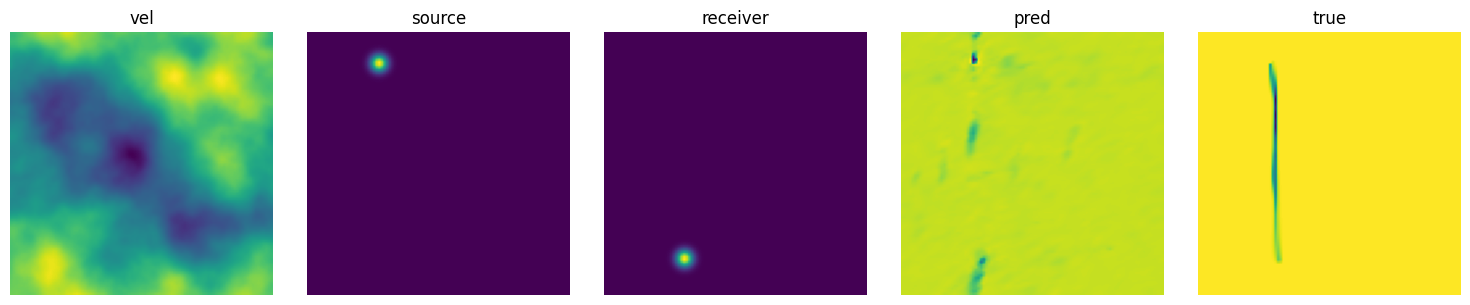

In [ ]:
if out_sample1.shape[1] == 1:
    out_sample1 = np.squeeze(out_sample1, axis=1)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

print (x_sample.cpu().shape)

# Display the images
axs[0].imshow(x_sample.cpu()[0,:,:,0], cmap='viridis')  # you can change the colormap if needed
axs[0].set_title("vel")
axs[0].axis('off')  # Hide the axis values

# Display the images
axs[1].imshow(x_sample.cpu()[0,:,:,1], cmap='viridis')  # you can change the colormap if needed
axs[1].set_title("source")
axs[1].axis('off')  # Hide the axis values

# Display the images
axs[2].imshow(x_sample.cpu()[0,:,:,2], cmap='viridis')  # you can change the colormap if needed
axs[2].set_title("receiver")
axs[2].axis('off')  # Hide the axis values

axs[3].imshow(out_sample1[0], cmap='viridis')  # you can change the colormap if needed
axs[3].set_title("pred")
axs[3].axis('off')  # Hide the axis values

axs[4].imshow(y_sample[0], cmap='viridis')
axs[4].set_title("true")
axs[4].axis('off')  # Hide the axis values

plt.tight_layout()
plt.show()

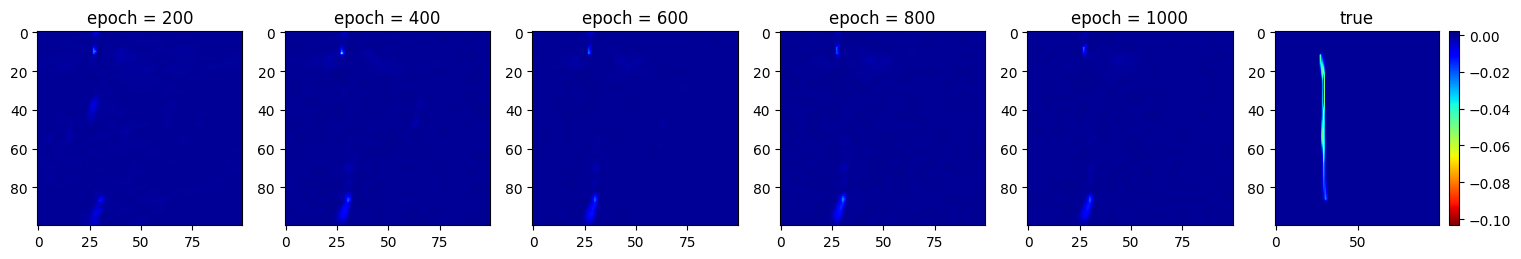

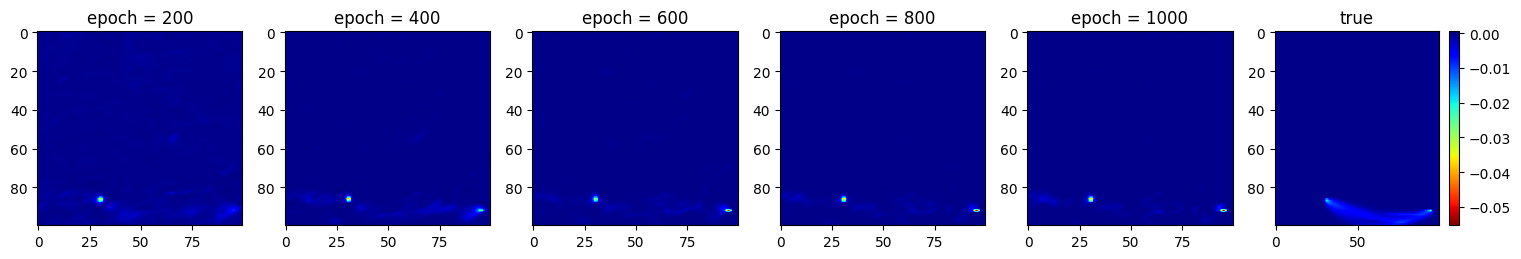

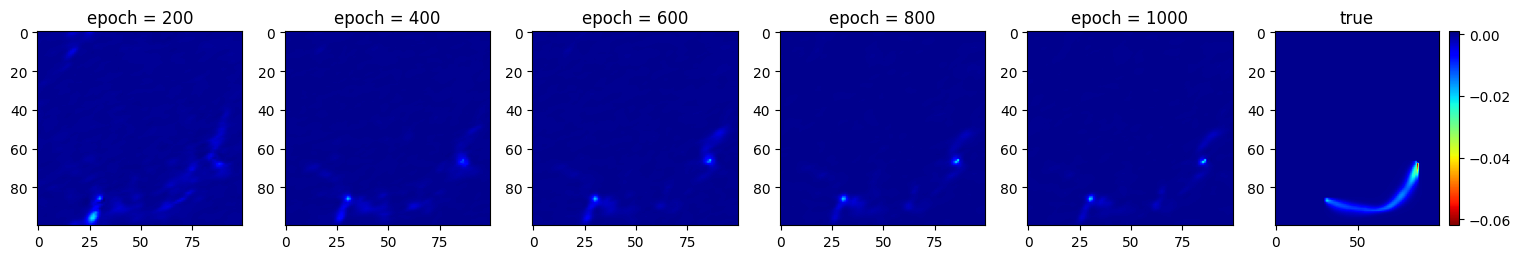

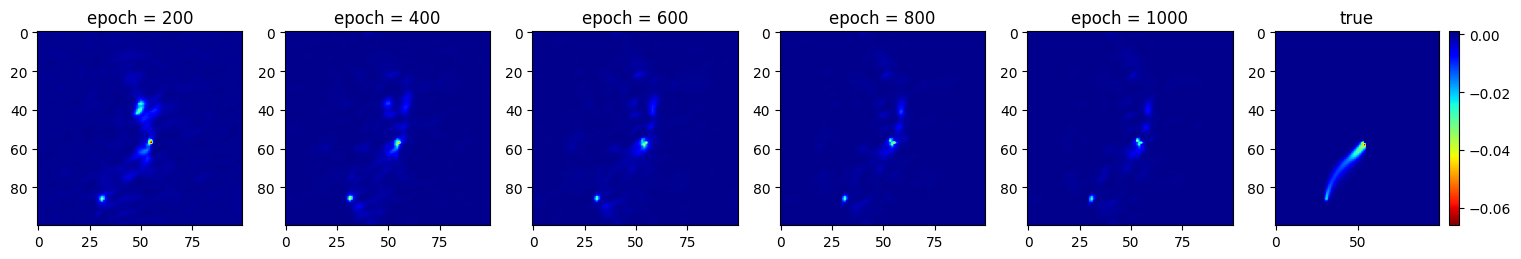

In [ ]:
for i in [0, 5, 10, 15]:
    # Display the images
    num_images = 6

    plt.figure(figsize=(15,2.7))

    images = [img[i] for img in [out_sample1, out_sample2, out_sample3, out_sample4, out_sample5, y_sample]]
    labels = [f"epoch = {(i+1) * 200}" for i in range(num_images-1)] + ["true"]

    scale_min = np.min([np.min(x) for x in images[:num_images-1]] + [torch.min(images[-1])])
    scale_max = np.max([np.max(x) for x in images[:num_images-1]] + [torch.max(images[-1])])

    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, vmin=scale_min, vmax=scale_max, cmap='jet_r', aspect='auto')
        plt.title(label)

    plt.tight_layout()
    plt.colorbar()
    plt.show()

In [ ]:
data_iter = iter(train_loader)
x_sample, y_sample = next(data_iter)
x_sample, y_sample = next(data_iter)
x_sample, y_sample = x_sample.float(), y_sample.float()
# x_sample = x_sample.unsqueeze(-1)
if torch.cuda.is_available():
    x_sample = x_sample.cuda()
y_sample = y_normalizer.decode(y_sample)

# Make sure your model is in evaluation mode for inference
fno_model200.eval()
fno_model400.eval()
fno_model600.eval()
fno_model800.eval()
fno_model1000.eval()

# Forward pass
with torch.no_grad():  # Deactivate gradients for the following code
    out_sample1 = y_normalizer.decode(fno_model200(x_sample))
    # y_normalizer.decode(y_sample)
    out_sample2 = y_normalizer.decode(fno_model400(x_sample))
    out_sample3 = y_normalizer.decode(fno_model600(x_sample))
    out_sample4 = y_normalizer.decode(fno_model800(x_sample))
    out_sample5 = y_normalizer.decode(fno_model1000(x_sample))
out_sample1 = out_sample1.detach().cpu().numpy()
out_sample2 = out_sample2.detach().cpu().numpy()
out_sample3 = out_sample3.detach().cpu().numpy()
out_sample4 = out_sample4.detach().cpu().numpy()
out_sample5 = out_sample5.detach().cpu().numpy()

if out_sample1.shape[1] == 1:
    out_sample1 = np.squeeze(out_sample1, axis=1)
    out_sample2 = np.squeeze(out_sample2, axis=1)
    out_sample3 = np.squeeze(out_sample3, axis=1)
    out_sample4 = np.squeeze(out_sample4, axis=1)
    out_sample5 = np.squeeze(out_sample5, axis=1)

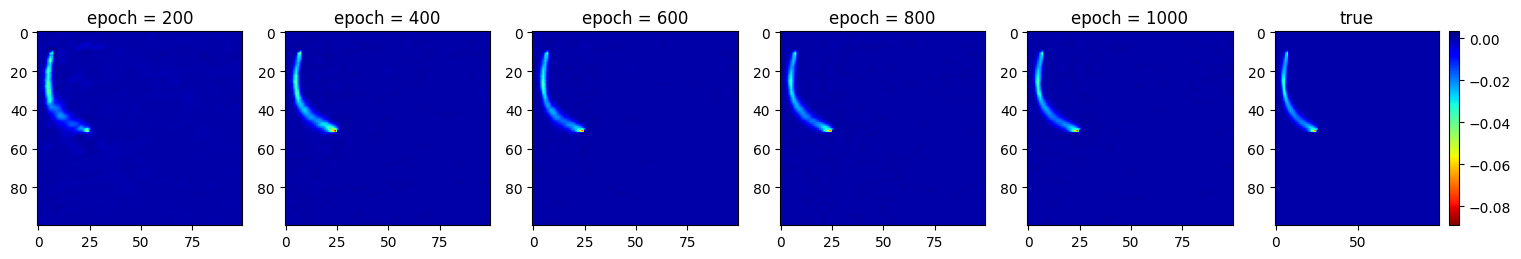

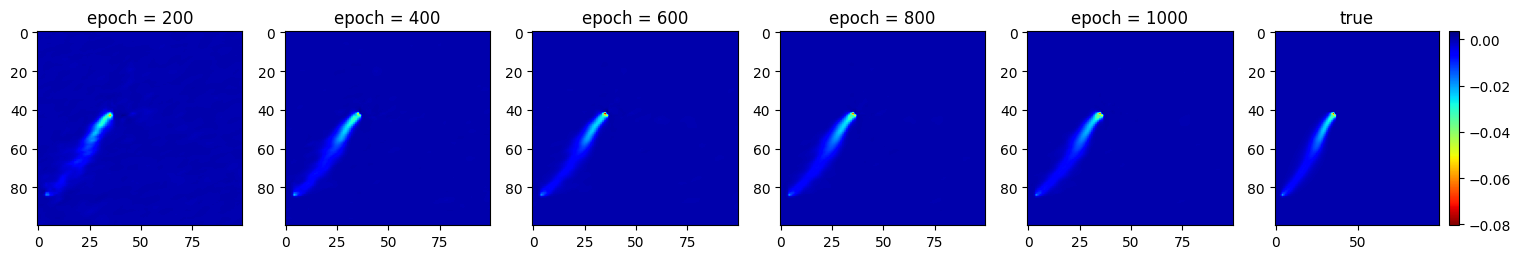

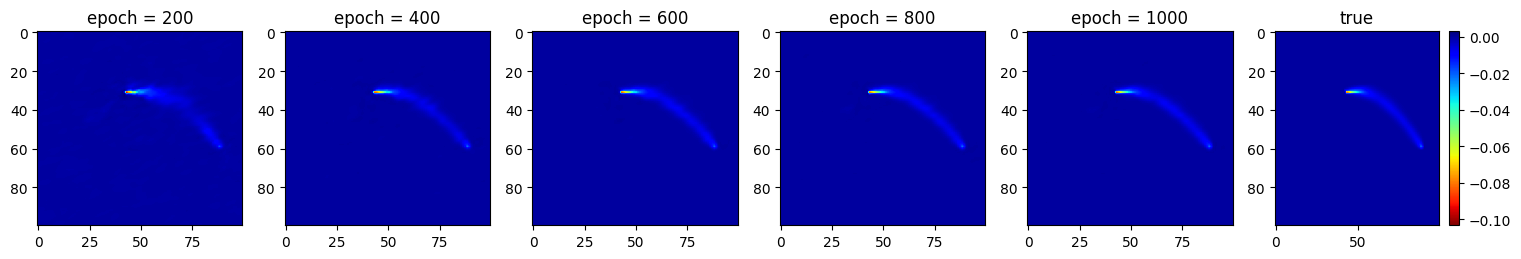

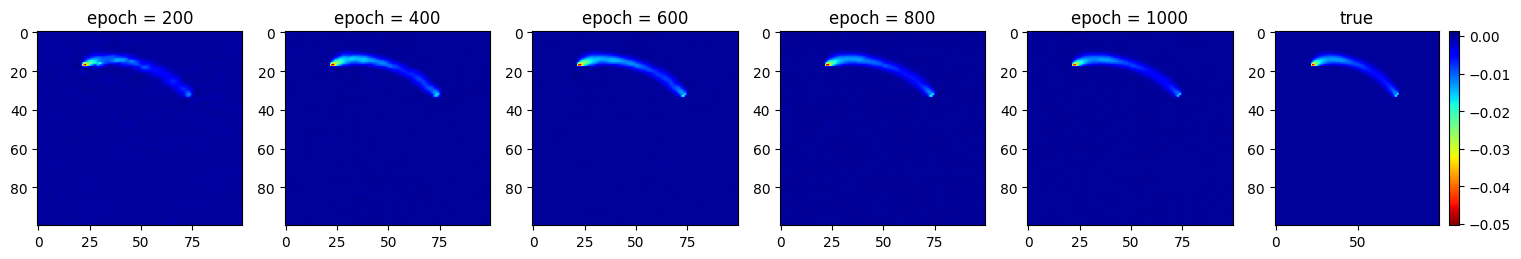

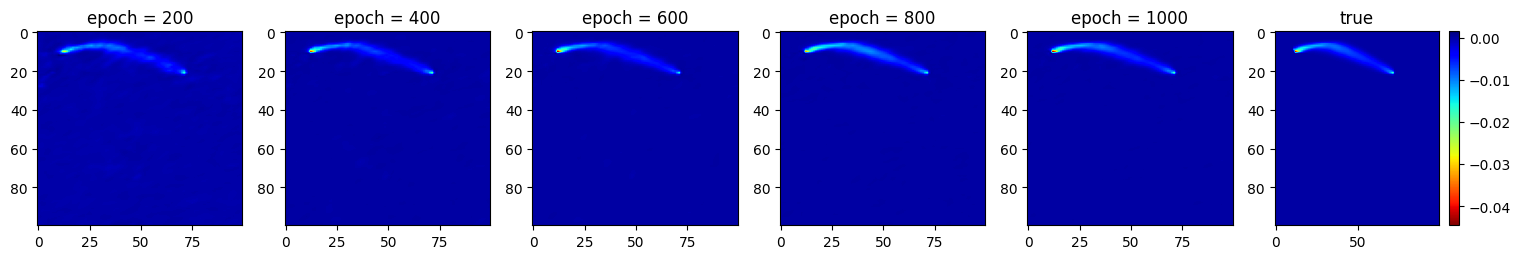

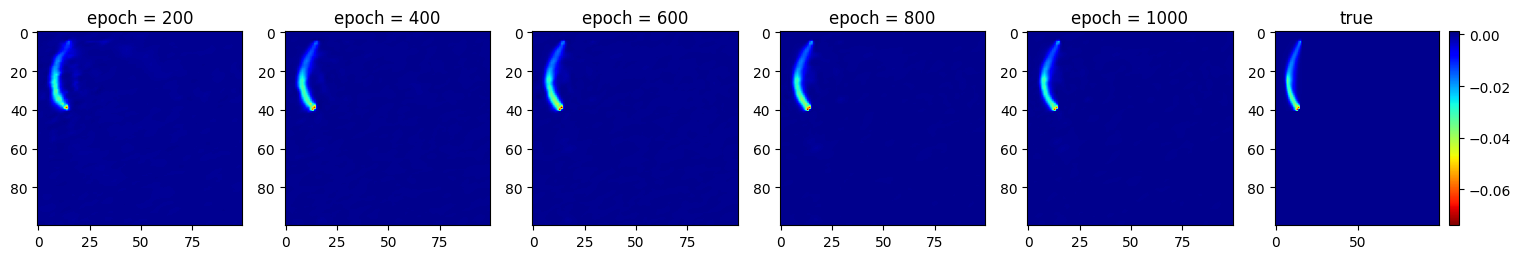

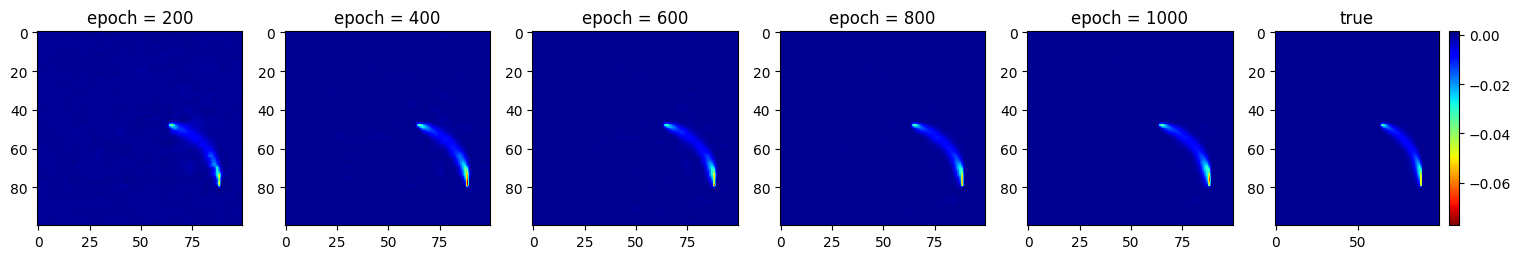

In [ ]:
for i in range(9, 16):
    # Display the images
    num_images = 6

    plt.figure(figsize=(15,2.7))

    images = [img[i] for img in [out_sample1, out_sample2, out_sample3, out_sample4, out_sample5, y_sample]]
    labels = [f"epoch = {(i+1) * 200}" for i in range(num_images-1)] + ["true"]

    scale_min = np.min([np.min(x) for x in images[:num_images-1]] + [torch.min(images[-1])])
    scale_max = np.max([np.max(x) for x in images[:num_images-1]] + [torch.max(images[-1])])

    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, vmin=scale_min, vmax=scale_max, cmap='jet_r', aspect='auto')
        plt.title(label)

    plt.tight_layout()
    plt.colorbar()
    plt.show()

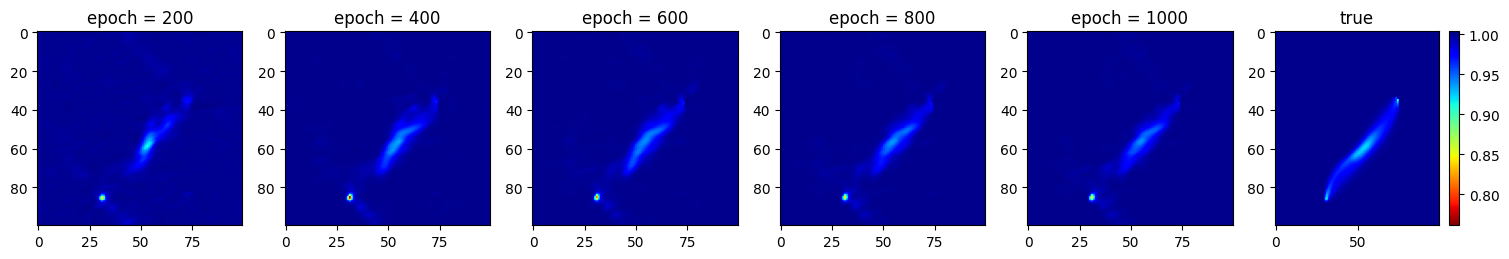

In [ ]:
# # Display the images
# num_images = 6

# plt.figure(figsize=(15,2.7))

# images = [y_normalizer.decode(img[0]) for img in [out_sample1, out_sample2, out_sample3, out_sample4, out_sample5, y_sample]]
# labels = [f"epoch = {(i+1) * 200}" for i in range(num_images-1)] + ["true"]

# scale_min = np.min([np.min(x) for x in images[:num_images-1]] + [torch.min(images[-1])])
# scale_max = np.max([np.max(x) for x in images[:num_images-1]] + [torch.max(images[-1])])

# for i, (img, label) in enumerate(zip(images, labels)):
#     plt.subplot(1, num_images, i+1)
#     plt.imshow(img, vmin=scale_min, vmax=scale_max, cmap='jet_r', aspect='auto')
#     plt.title(label)

# plt.tight_layout()
# plt.colorbar()
# plt.show()

In [ ]:
scale_max

1.0034673

## Load Saved Models

If on GPU:

In [ ]:
# torch.save(fno_model, '/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Data/model-1000-epoch-1000')
fno_model200 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-200')
fno_model400 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-400')
fno_model600 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-600')
fno_model800 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-800')
fno_model1000 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-1000')

fno_model = fno_model1000

If on CPU:

In [ ]:
# torch.save(fno_model, '/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Data/model-1000-epoch-1000')
fno_model200 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-200', map_location=torch.device('cpu'))
fno_model400 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-400', map_location=torch.device('cpu'))
fno_model600 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-600', map_location=torch.device('cpu'))
fno_model800 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-800', map_location=torch.device('cpu'))
fno_model1000 = torch.load('/content/drive/MyDrive/new (CS101 Eikonal Tomography)/Models/model-1000-v2-epoch-1000', map_location=torch.device('cpu'))

fno_model = fno_model1000